In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter, gaussian_filter1d

from utils.processing import open_preprocessed_data, add_filtered_V

In [13]:
DIR = 'preprocessed_dataset'
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

# 1. Load datasets
dfs_dict = {}  # <------- now we use this dict 
for n in dfs_names:
    fname = os.path.join(DIR, f'{n}.pkl')
    subtraj_list = open_preprocessed_data(fname)
    dfs_dict[n] = subtraj_list

In [14]:
filtered_V_dfs_dict = {}
for k, df_list in dfs_dict.items():
    subtraj_list = []
    for subtraj in df_list:
        subtraj_list.append(add_filtered_V(subtraj))

    filtered_V_dfs_dict[k] = subtraj_list

filtered_V_dfs_dict['tr3'][0].head(5)

,time,x,y,angles,delta_angle,step_length,Vx,Vy,V
0,1.0010,-2.399949,-0.949371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.3025,-2.462182,-0.735218,343.796298,343.796298,0.223013,1.674448,1.357123,2.724306
2,1.6040,-2.352719,0.331526,5.858822,22.062524,1.072345,2.653272,1.783814,3.890415
3,1.9055,0.000695,0.665046,81.933921,76.075099,2.376930,3.572229,2.366677,5.084405
4,2.2070,2.790567,1.533511,72.709034,350.775113,2.921919,4.114708,3.194715,6.078502


In [43]:
def minmax_normalize(x):
    return (x - x.min()) / (x.max() - x.min())


def speed_z_score_norm(vx, vy, mean, sd, eps=1e-2):
    vb = ((vx ** 2) + (vy ** 2)) ** 0.5
    vn = abs((vb - mean) / (sd + eps))

    vx = vn * vx / (vb + eps)
    vy = vn * vy / (vb + eps)
    return vx, vy


def kill_nans(x, grid_size, verbose=False):
    for i in range(grid_size):
        for j in range(grid_size):
            if np.isnan(x.iloc[i, j]):
                if verbose:
                    print(f'NaN in place: {i}, {j}')
                idx_list = np.array([[i-1, j-1], [i-1, j], [i-1, j+1],
                                        [i, j-1]  ,           [i, j+1],
                                        [i+1, j-1], [i+1, j], [i+1, j+1]])
                
                idx_to_drop = np.where((idx_list < 0) | (idx_list > grid_size-1))[0]
                if verbose:
                    print(f'Dropping indexes: {idx_to_drop}')
                dropping_mask = np.ones(idx_list.shape[0], dtype=bool)
                dropping_mask[idx_to_drop] = False
                idx_list = idx_list[dropping_mask]

                x.iloc[i, j] = np.nanmean(x.iloc[idx_list[:, 0], idx_list[:, 1]])
    return x


def build_vector_field(df, grid_size,
                       title_name, z_norm,
                       lscale=0.17, color_map='Reds',
                       eps=1e-2, unsmoothed_colors=False, save=False):
    
    df = df.reset_index(drop=True)
    binx = np.linspace(df["x"].min() - eps, df["x"].max() + eps,
                       grid_size+1)
    x_binned = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min() - eps, df["y"].max() + eps,
                       grid_size+1)
    y_binned = pd.cut(df.y, biny, right=False)

    df_binned_mean = df.groupby([x_binned, y_binned],
                                 observed=False).mean()
    dfvx = pd.DataFrame(df_binned_mean.loc[:, 'Vx']).unstack()
    dfvy = pd.DataFrame(df_binned_mean.loc[:, 'Vy']).unstack()

    # For z_normalization
    if z_norm:
        df_binned_sd = df.groupby([x_binned, y_binned],
                                observed=False).std()
        mV = pd.DataFrame(df_binned_mean.loc[:, 'V']).unstack()
        sdV = pd.DataFrame(df_binned_sd.loc[:, 'V']).unstack()
        mV =  kill_nans(mV, grid_size, verbose=False)
        sdV = kill_nans(sdV, grid_size, verbose=False)

    # Average Nans with all neightboring values
    dfvx = kill_nans(dfvx, grid_size)
    dfvy = kill_nans(dfvy, grid_size)

    vector_field_matrix = []
    for i in range(grid_size):
        vector_column = []
        for j in range(grid_size):
            if z_norm:
                vx, vy = speed_z_score_norm(dfvx.iloc[i, j], dfvy.iloc[i, j],
                                            mV.iloc[i, j], sdV.iloc[i, j]) 
            else: 
                vx = dfvx.iloc[i, j]
                vy = dfvy.iloc[i, j]

            vector_column.append([binx[i], biny[j], vx, vy])
        vector_field_matrix.append(vector_column)

    vector_field_matrix = np.array(vector_field_matrix)

    vectx = vector_field_matrix[:, :, 2]
    vecty = vector_field_matrix[:, :, 3]

    vectx_smoothed = gaussian_filter(vectx, sigma=1)
    vecty_smoothed = gaussian_filter(vecty, sigma=1)

    L_matrix = (vectx_smoothed**2 + vecty_smoothed**2)**0.5
    L_matrix_unsmoothed = (vectx**2 + vecty**2)**0.5 

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.axvline(0, c='black', alpha=0.2)
    ax.axhline(0, c='black', alpha=0.2)
    
    L = L_matrix_unsmoothed if unsmoothed_colors else L_matrix
    min_val, max_val = np.min(L), np.max(L)
    cmap = plt.cm.get_cmap(color_map)
    color_list = cmap(L)

    for i in range(grid_size):
        for j in range(grid_size):
            l = L_matrix[i, j]
            im1 = ax.quiver(vector_field_matrix[i, j, 0],
                            vector_field_matrix[i, j, 1],
                            vectx_smoothed[i, j], vecty_smoothed[i, j],
                            color=color_list[i, j], units='xy', pivot='middle',
                            scale=lscale*l, width=0.6)
    plt.title(f"Vector Field of Speed, {title_name}")

    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(vmin=min_val, vmax=max_val)
    plt.colorbar(sm, ax=ax)
    ax.set_facecolor('#CACACA')
    if save:
        plt.savefig(os.path.join(os.getcwd(), 'images',
                                 title_name + '_NewVelocityField.png'),
                    dpi=150)
    plt.show()


# build_vector_field(dff, grid_size=10,
#                    title_name='test_NORMALIZED',
#                    z_norm=True,
#                    lscale=0.17,
#                    color_map='Reds',
#                    unsmoothed_colors=False, save=False)

# build_vector_field(dff, grid_size=10,
#                    title_name='test',
#                    z_norm=False,
#                    lscale=0.17,
#                    color_map='Reds',
#                    unsmoothed_colors=False, save=False)

/tmp/ipykernel_48384/830662866.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(color_map)


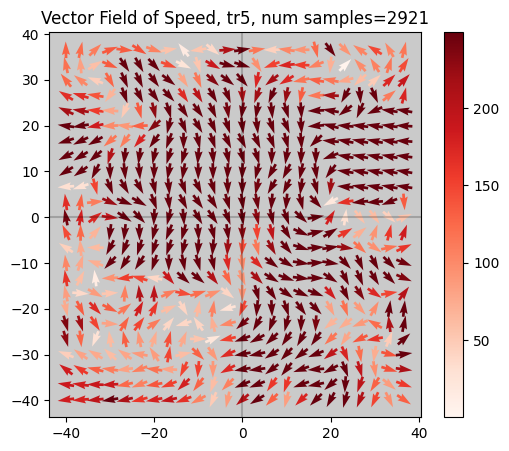

In [47]:
# for k, filtered_df_list in filtered_V_dfs_dict.items():
    # print(k)

k = 'tr5'
filtered_df_list = filtered_V_dfs_dict[k]
merged_subtrajs = pd.concat(filtered_df_list)
build_vector_field(merged_subtrajs,
                    grid_size=24,
                    title_name=f'{k}, num samples={merged_subtrajs.shape[0]}',
                    z_norm=True,
                    lscale=0.27,
                    color_map='Reds',
                    unsmoothed_colors=False,
                    save=False)
    # break

/tmp/ipykernel_31768/2874730253.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(color_map)


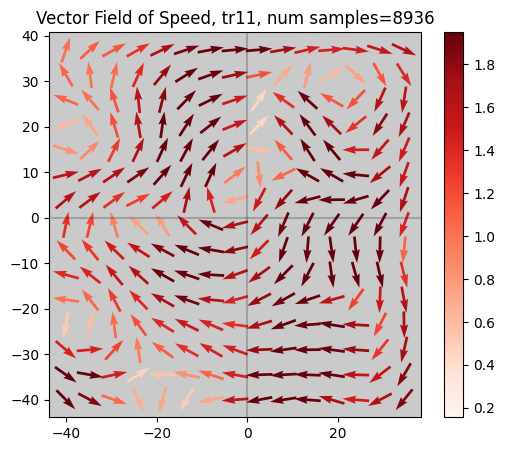

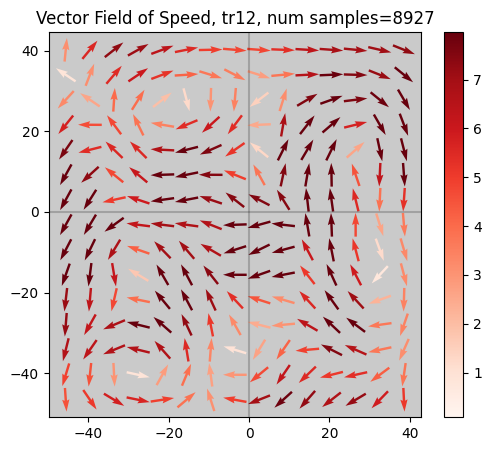

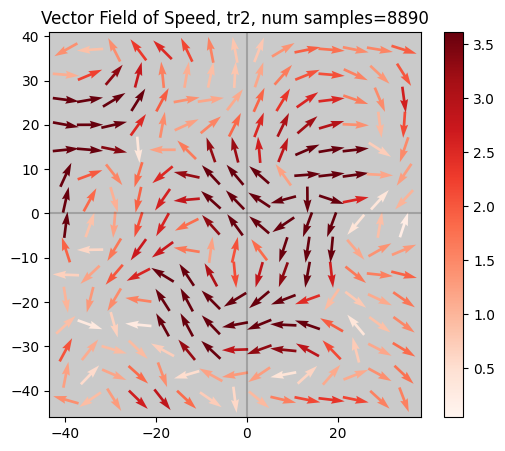

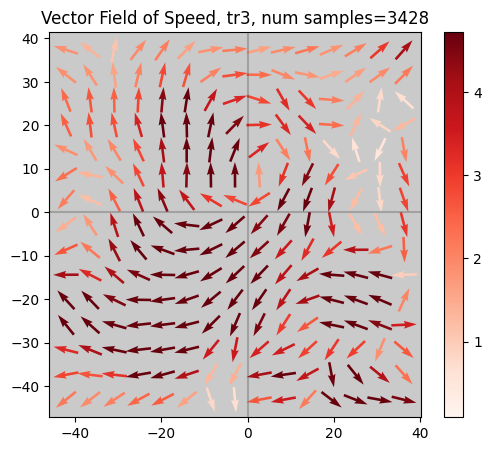

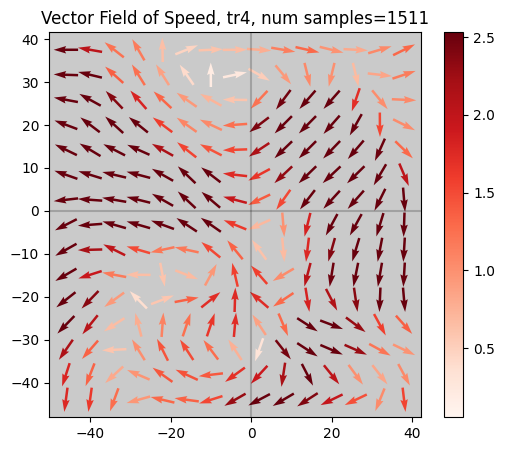

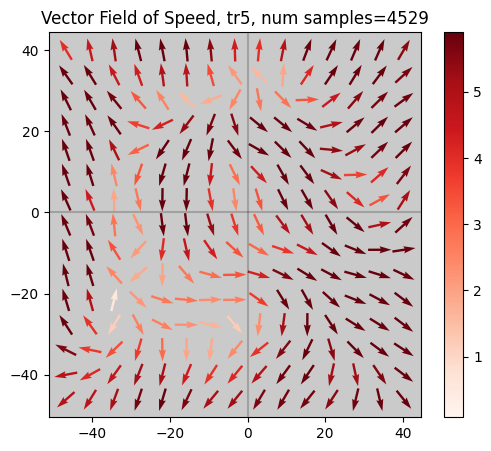

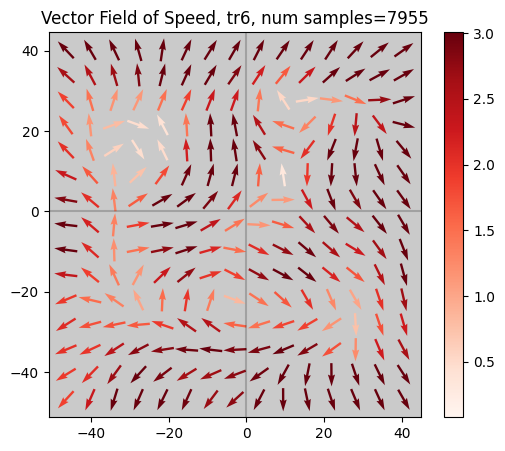

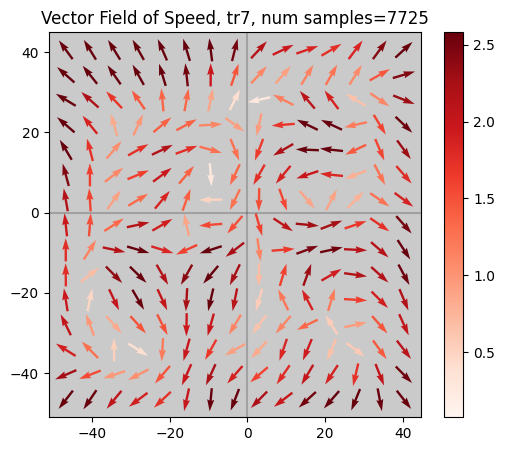

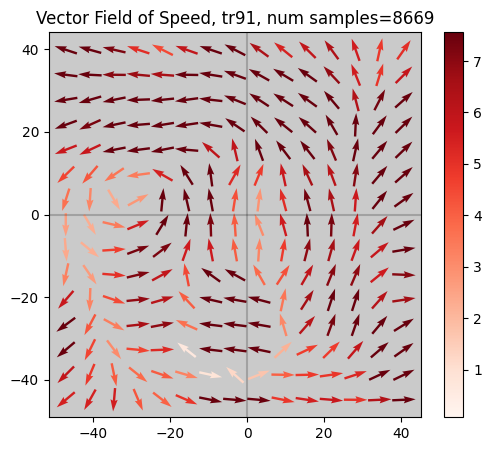

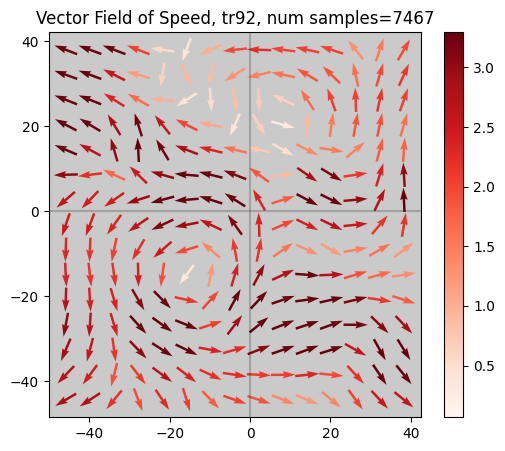

In [83]:
for k, filtered_df_list in filtered_V_dfs_dict.items():
    
    merged_subtrajs = pd.concat(filtered_df_list)
    build_vector_field(merged_subtrajs,
                       grid_size=15,
                       title_name=f'{k}, num samples={merged_subtrajs.shape[0]}',
                       z_norm=True,
                       lscale=0.17,
                       color_map='Reds',
                       unsmoothed_colors=False,
                       save=False)

### Plotting of turning maps

In [84]:
from utils.processing import normalize_angles_2pi

def plotTurnsMap(df, grid_size,
                title_name, z_norm,
                eps = 1e-2,
                color_map='twilight',
                save=False):
    
    df = df.reset_index(drop=True)
    binx = np.linspace(df["x"].min() - eps, df["x"].max() + eps,
                       grid_size+1)
    x_binned = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min() - eps, df["y"].max() + eps,
                       grid_size+1)
    y_binned = pd.cut(df.y, biny, right=False)

    df_binned_mean = df.groupby([x_binned, y_binned],
                                 observed=False).mean()
    dfvx = pd.DataFrame(df_binned_mean.loc[:, 'Vx']).unstack()
    dfvy = pd.DataFrame(df_binned_mean.loc[:, 'Vy']).unstack()

    # For z_normalization
    if z_norm:
        df_binned_sd = df.groupby([x_binned, y_binned],
                                observed=False).std()
        mV = pd.DataFrame(df_binned_mean.loc[:, 'V']).unstack()
        sdV = pd.DataFrame(df_binned_sd.loc[:, 'V']).unstack()
        mV =  kill_nans(mV, grid_size)
        sdV = kill_nans(sdV, grid_size)

    # Average Nans with all neightboring values
    dfvx = kill_nans(dfvx, grid_size)
    dfvy = kill_nans(dfvy, grid_size)

    vector_field_matrix = []
    for i in range(grid_size):
        vector_column = []
        for j in range(grid_size):
            if z_norm:
                vx, vy = speed_z_score_norm(dfvx.iloc[i, j], dfvy.iloc[i, j],
                                            mV.iloc[i, j], sdV.iloc[i, j]) 
            else: 
                vx = dfvx.iloc[i, j]
                vy = dfvy.iloc[i, j]

            vector_column.append([binx[i], biny[j], vx, vy])
        vector_field_matrix.append(vector_column)

    vector_field_matrix = np.array(vector_field_matrix)
    vectx = vector_field_matrix[:, :, 2]
    vecty = vector_field_matrix[:, :, 3]
    
    Xx = np.arctan2(vectx, vecty) + np.pi
    Nres = normalize_angles_2pi(Xx)  
    arct = (np.rad2deg(Nres) + 180) % 360
    
    plt.figure(figsize=(5, 5))
    arct = np.rot90(arct)
    sns.heatmap(arct, cmap=color_map, square=True, 
                xticklabels=False, yticklabels=False)
    plt.title(title_name + ', average degrees')
    if save:
        plt.savefig(os.path.join(os.getcwd(), 'images',
                                 title_name + '_NewVelocityField.png'),
                    dpi=150)
    plt.show()
    
    return arct

In [15]:
# _ = plotTurnsMap(dff, grid_size=10,
#                 title_name='test',
#                 z_norm=True,
#                 color_map='twilight',
#                 save=False)

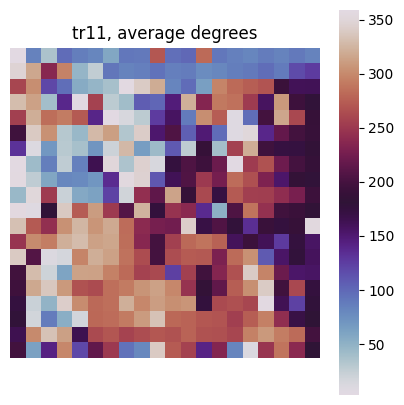

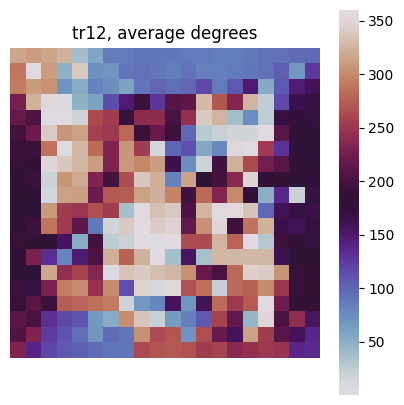

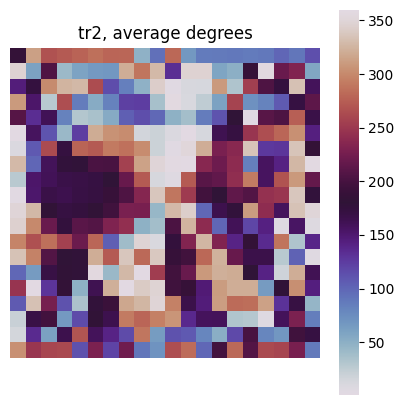

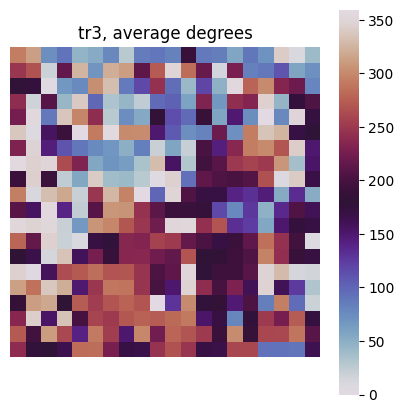

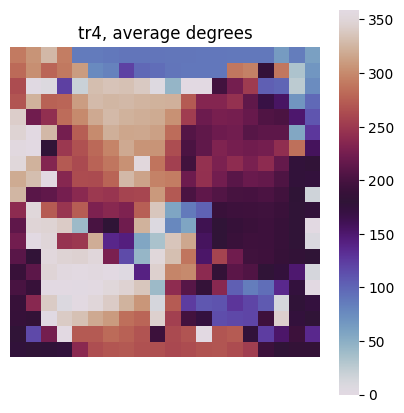

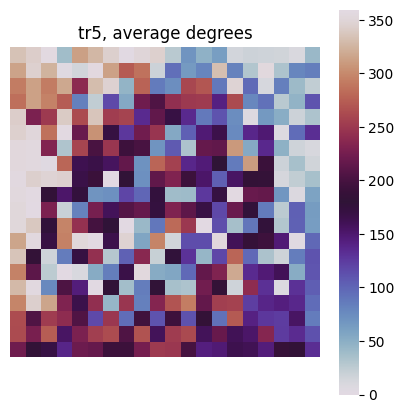

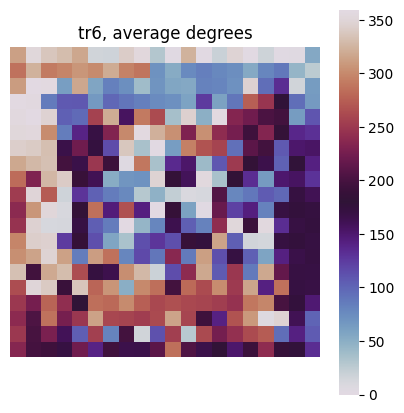

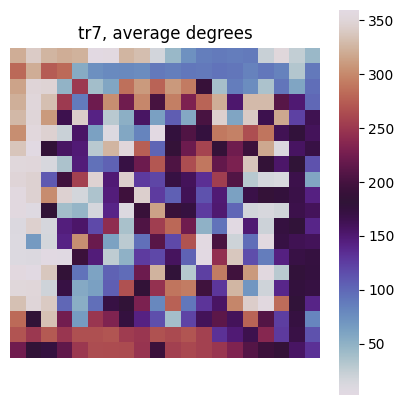

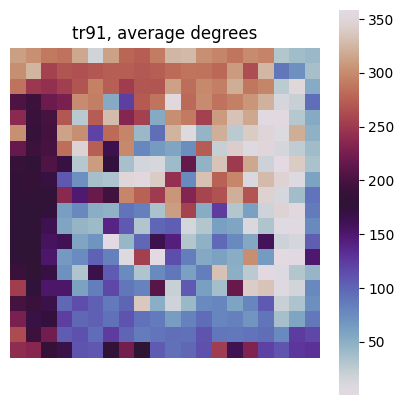

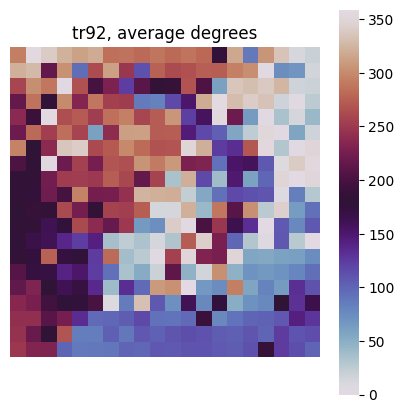

In [85]:
# for i, filtered_df in enumerate(dfs):
for k, filtered_df_list in filtered_V_dfs_dict.items():
    
    merged_subtrajs = pd.concat(filtered_df_list)

    _ = plotTurnsMap(merged_subtrajs,
                     grid_size=20,
                     title_name=f'{k}',
                     z_norm=True,
                     color_map='twilight',
                     save=False)